In [1]:
import os
import sys
print(sys.executable)
import ember
import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve

/home/noyan/anaconda2/envs/emberenv2/bin/python


/home/noyan/anaconda2/envs/emberenv2/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
data_dir = "/stash/dataset/ember/ember_data/" # change this to where you unzipped https://pubdata.endgame.com/ember/ember_dataset.tar.bz

In [3]:
ember.create_vectorized_features(data_dir)
_ = ember.create_metadata(data_dir)

Vectorizing training set


100%|██████████| 900000/900000 [02:14<00:00, 6682.54it/s]


Vectorizing test set


100%|██████████| 200000/200000 [00:24<00:00, 8109.22it/s]


In [15]:
emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2017.txt"))

/home/noyan/anaconda2/envs/emberenv2/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


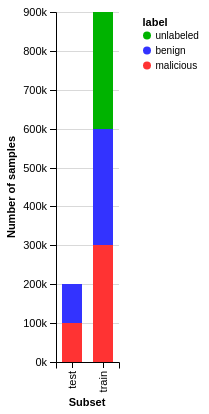

In [21]:
plotdf = emberdf.copy()
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('subset:O', axis=alt.Axis(title='Subset')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=["#00b300", "#3333ff", "#ff3333"]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

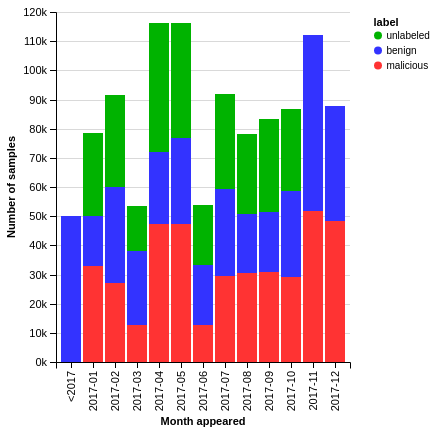

In [17]:
plotdf = emberdf.copy()
plotdf.loc[plotdf["appeared"] < "2017-01", "appeared"] = " <2017"
gbdf = plotdf.groupby(["appeared", "label"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('appeared:O', axis=alt.Axis(title='Month appeared')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=["#00b300", "#3333ff", "#ff3333"]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

In [22]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [23]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.3f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.3f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9991123269999999

Ember Model Performance at 1% FPR:
Threshold: 0.529
False Positive Rate: 0.998%
False Negative Rate: 1.838%
Detection Rate: 98.162%

Ember Model Performance at 0.1% FPR:
Threshold: 0.871
False Positive Rate: 0.099%
False Negative Rate: 7.009%
Detection Rate: 92.991%


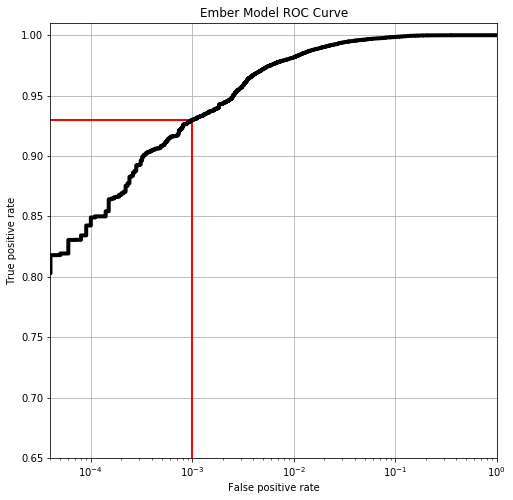

In [20]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

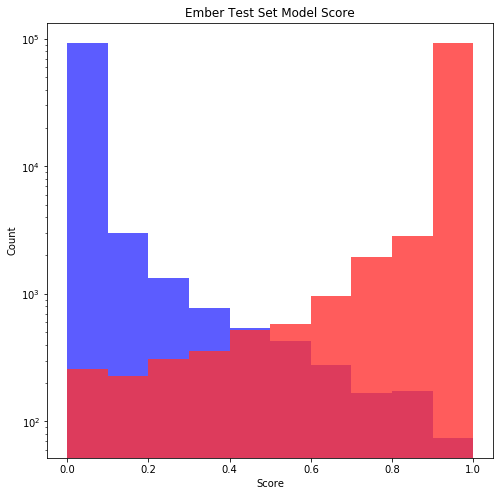

In [10]:
fig = plt.figure(figsize=(8, 8))
testdf[testdf["label"] == 0].y_pred.hist(range=[0, 1], bins=10, color="#3333ff", alpha=0.8, label="benign")
testdf[testdf["label"] == 1].y_pred.hist(range=[0, 1], bins=10, color="#ff3333", alpha=0.8, label="malicious")
plt.gca().set_yscale("log", nonposy="clip")
plt.gca().grid(False)
plt.xlabel("Score")
plt.ylabel("Count")
_ = plt.title("Ember Test Set Model Score")

In [26]:
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "model_vboat.txt"))

In [27]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [31]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.3f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.3f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9989913624000001

Ember Model Performance at 1% FPR:
Threshold: 0.538
False Positive Rate: 0.999%
False Negative Rate: 1.884%
Detection Rate: 98.116%

Ember Model Performance at 0.1% FPR:
Threshold: 0.896
False Positive Rate: 0.100%
False Negative Rate: 8.570%
Detection Rate: 91.43%


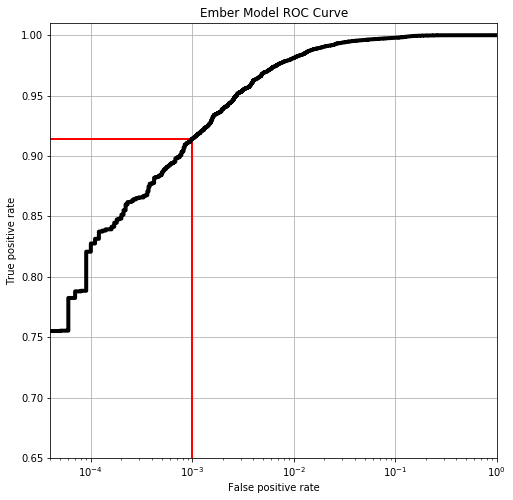

In [29]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

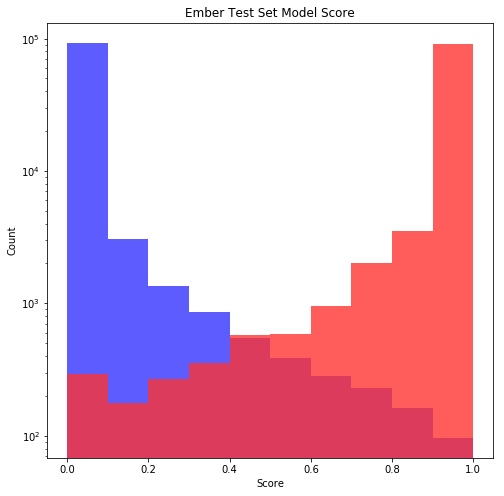

In [30]:
fig = plt.figure(figsize=(8, 8))
testdf[testdf["label"] == 0].y_pred.hist(range=[0, 1], bins=10, color="#3333ff", alpha=0.8, label="benign")
testdf[testdf["label"] == 1].y_pred.hist(range=[0, 1], bins=10, color="#ff3333", alpha=0.8, label="malicious")
plt.gca().set_yscale("log", nonposy="clip")
plt.gca().grid(False)
plt.xlabel("Score")
plt.ylabel("Count")
_ = plt.title("Ember Test Set Model Score")